In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kfu-hw-1-classification-2024/test.tsv
/kaggle/input/kfu-hw-1-classification-2024/train.tsv


In [2]:
!pip install pymorphy2

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from nltk import download
import pymorphy2
from transformers import pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
import fasttext
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout, Concatenate
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 73.5 MB/s eta 0:00:00:00:010:01
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=cfed64a72118a7b909eb2f03a0118eaf705f8ba2712973d6b8e9a6d8ede93d00
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [3]:
test_data = pd.read_csv('/kaggle/input/kfu-hw-1-classification-2024/test.tsv')
train_data = pd.read_csv('/kaggle/input/kfu-hw-1-classification-2024/train.tsv')

train_data.head()

,id,tweet,class
0,760402871867367424,"Настало время для ингаляторов. Дружок, Сальбут...",0
1,1035908416869462016,15) На прошлой зимней олимпиаде большинство лы...,1
2,1089839736427032577,Не соглашусь с заменой ЗОК на метопролол в так...,0
3,779671488748224513,"@di2m1 мезим Смекта Если отравление, то лоперамид",0
4,738309299756240897,Уберите микроволновки и имодиум Действуют соу...,0


**EDA**

In [4]:
train_data['class'].value_counts()

class
0    8683
1     832
Name: count, dtype: int64

In [5]:
print(train_data.isnull().sum())
print(test_data.isnull().sum())

id       0
tweet    0
class    0
dtype: int64
id       0
tweet    0
dtype: int64


In [6]:
print(train_data['tweet'].duplicated().sum())

1


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

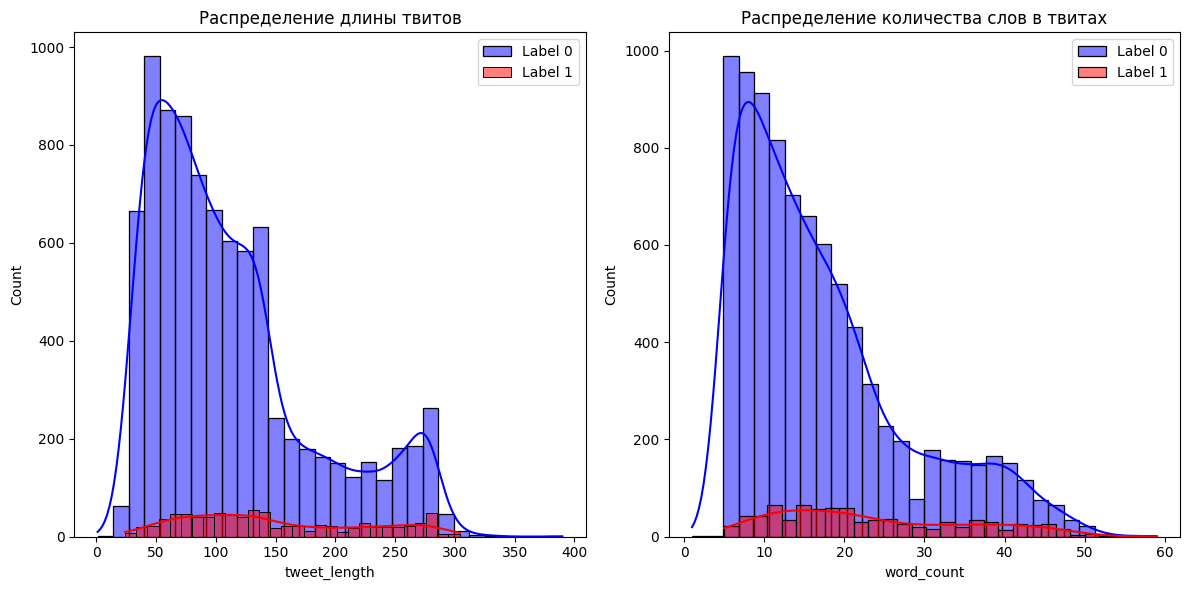

In [7]:
train_data['tweet_length'] = train_data['tweet'].apply(len)
train_data['word_count'] = train_data['tweet'].apply(lambda x: len(x.split()))
test_data['tweet_length'] = test_data['tweet'].apply(len)
test_data['word_count'] = test_data['tweet'].apply(lambda x: len(x.split()))



plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(train_data[train_data['class'] == 0]['tweet_length'], kde=True, color='blue', label='Label 0', bins=30)
sns.histplot(train_data[train_data['class'] == 1]['tweet_length'], kde=True, color='red', label='Label 1', bins=30)
plt.title("Распределение длины твитов")
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(train_data[train_data['class'] == 0]['word_count'], kde=True, color='blue', label='Label 0', bins=30)
sns.histplot(train_data[train_data['class'] == 1]['word_count'], kde=True, color='red', label='Label 1', bins=30)
plt.title("Распределение количества слов в твитах")
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data['class'], random_state=42)

**Feature Engineering**

In [9]:
!pip install spacy
!python -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 59.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 69.1 MB/s eta 0:00:00:00:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [10]:
# Text normalization

download('stopwords')
download('punkt')

stop_words = set(stopwords.words('russian'))
morph = pymorphy2.MorphAnalyzer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [morph.parse(token)[0].normal_form for token in tokens if token.isalnum() and token not in stop_words]
    return ' '.join(tokens)

train_data['cleaned_tweet'] = train_data['tweet'].apply(preprocess_text)
test_data['cleaned_tweet'] = test_data['tweet'].apply(preprocess_text)
val_data['cleaned_tweet'] = val_data['tweet'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
nlp = spacy.load('ru_core_news_sm')

def pos_analysis(text):
    doc = nlp(text)
    return [token.pos_ for token in doc]


train_data['pos_tags'] = train_data['cleaned_tweet'].apply(pos_analysis)
test_data['pos_tags'] = test_data['cleaned_tweet'].apply(pos_analysis)
val_data['pos_tags'] = val_data['cleaned_tweet'].apply(pos_analysis)

train_data.head(5)

,id,tweet,class,tweet_length,word_count,cleaned_tweet,pos_tags
7228,1150716954623299589,"вообще пить таблетки без рецепта ну такое, там...",0,280,49,вообще пить таблетка рецепт такой наверное инд...,"[ADV, VERB, NOUN, NOUN, DET, ADV, ADV, VERB, D..."
6648,1100682624065064960,Спасибо мирозданию за вентолин. Я хз уже че де...,0,244,40,спасибо мироздание вентолин хз че делать свой ...,"[NOUN, NOUN, NOUN, PART, PRON, VERB, DET, NOUN..."
281,952559719339712512,мне бы кто из паксила сделал,0,28,6,паксила сделать,"[VERB, VERB]"
7260,824477611480981508,"за неимением шарфов дышу через пуховой платок,...",0,106,17,неимение шарф дышать пуховый платок плюс венто...,"[NOUN, NOUN, VERB, ADJ, NOUN, ADP, NOUN, NUM, ..."
4491,656520931679055872,"Харьковские телки под баклофеном , через 10 ми...",0,137,21,харьковский тёлка баклофен 10 минута присоедин...,"[ADJ, NOUN, PROPN, NUM, NOUN, VERB, VERB, NOUN..."


In [12]:
# Sentiment analysis

classifier = pipeline("sentiment-analysis", model="blanchefort/rubert-base-cased-sentiment")

def analyze_sentiment(text):
    result = classifier(text)[0]  
    return result['label'], result['score']  

train_data[['sentiment_label', 'sentiment_score']] = train_data['cleaned_tweet'].apply(
    lambda x: pd.Series(analyze_sentiment(x))
)

test_data[['sentiment_label', 'sentiment_score']] = test_data['cleaned_tweet'].apply(
    lambda x: pd.Series(analyze_sentiment(x))
)

val_data[['sentiment_label', 'sentiment_score']] = val_data['cleaned_tweet'].apply(
    lambda x: pd.Series(analyze_sentiment(x))
)



# print(train_data)

config.json:   0%|          | 0.00/943 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/499 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


Топ-20 слов: [('это', 1102), ('ксанакс', 1070), ('прозак', 712), ('флуоксетин', 603), ('таблетка', 450), ('пить', 429), ('день', 419), ('флуоксетина', 355), ('который', 335), ('препарат', 331), ('такой', 318), ('ещё', 315), ('лоперамид', 311), ('сальбутамол', 311), ('год', 309), ('паксила', 302), ('тамифить', 298), ('просто', 293), ('очень', 270), ('рецепт', 256)]


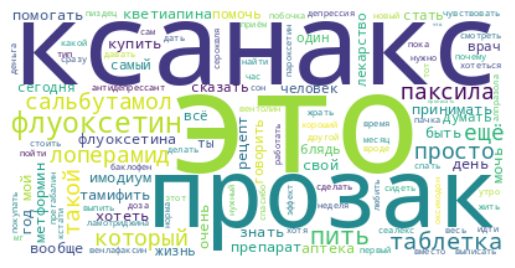

In [13]:
def get_top_n_words(corpus, n=None):
    words = ' '.join(corpus).split()
    return Counter(words).most_common(n)

all_tweets = train_data['cleaned_tweet']
top_words = get_top_n_words(all_tweets, n=20)
print("Топ-20 слов:", top_words)

wordcloud = WordCloud(background_color='white').generate(' '.join(all_tweets))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [14]:
train_data.head()

,id,tweet,class,tweet_length,word_count,cleaned_tweet,pos_tags,sentiment_label,sentiment_score
7228,1150716954623299589,"вообще пить таблетки без рецепта ну такое, там...",0,280,49,вообще пить таблетка рецепт такой наверное инд...,"[ADV, VERB, NOUN, NOUN, DET, ADV, ADV, VERB, D...",NEGATIVE,0.751548
6648,1100682624065064960,Спасибо мирозданию за вентолин. Я хз уже че де...,0,244,40,спасибо мироздание вентолин хз че делать свой ...,"[NOUN, NOUN, NOUN, PART, PRON, VERB, DET, NOUN...",POSITIVE,0.637986
281,952559719339712512,мне бы кто из паксила сделал,0,28,6,паксила сделать,"[VERB, VERB]",NEUTRAL,0.828173
7260,824477611480981508,"за неимением шарфов дышу через пуховой платок,...",0,106,17,неимение шарф дышать пуховый платок плюс венто...,"[NOUN, NOUN, VERB, ADJ, NOUN, ADP, NOUN, NUM, ...",NEUTRAL,0.768095
4491,656520931679055872,"Харьковские телки под баклофеном , через 10 ми...",0,137,21,харьковский тёлка баклофен 10 минута присоедин...,"[ADJ, NOUN, PROPN, NUM, NOUN, VERB, VERB, NOUN...",NEUTRAL,0.819142


In [15]:
train_data['sentiment_label'].value_counts()

sentiment_label
NEUTRAL     4014
NEGATIVE    2917
POSITIVE     681
Name: count, dtype: int64

In [16]:
print(train_data.describe())
print(test_data.describe())

             class  tweet_length   word_count  sentiment_score
count  7612.000000   7612.000000  7612.000000      7612.000000
mean      0.087493    115.430636    17.776012         0.785046
std       0.282575     69.655949    10.866814         0.075934
min       0.000000     20.000000     4.000000         0.341355
25%       0.000000     61.000000     9.000000         0.751495
50%       0.000000     98.000000    15.000000         0.796436
75%       0.000000    143.000000    23.000000         0.825434
max       1.000000    390.000000    59.000000         0.994892
       tweet_length   word_count  sentiment_score
count   1504.000000  1504.000000      1504.000000
mean     126.934840    19.541888         0.783576
std       72.732101    11.343466         0.080067
min       22.000000     5.000000         0.372410
25%       70.000000    11.000000         0.751478
50%      107.000000    16.000000         0.755613
75%      170.000000    26.000000         0.825128
max      283.000000    58.000000 

In [17]:
#Vectorization
#Class Disbalance
#Model learning


In [18]:
train_data.head(3)

,id,tweet,class,tweet_length,word_count,cleaned_tweet,pos_tags,sentiment_label,sentiment_score
7228,1150716954623299589,"вообще пить таблетки без рецепта ну такое, там...",0,280,49,вообще пить таблетка рецепт такой наверное инд...,"[ADV, VERB, NOUN, NOUN, DET, ADV, ADV, VERB, D...",NEGATIVE,0.751548
6648,1100682624065064960,Спасибо мирозданию за вентолин. Я хз уже че де...,0,244,40,спасибо мироздание вентолин хз че делать свой ...,"[NOUN, NOUN, NOUN, PART, PRON, VERB, DET, NOUN...",POSITIVE,0.637986
281,952559719339712512,мне бы кто из паксила сделал,0,28,6,паксила сделать,"[VERB, VERB]",NEUTRAL,0.828173


In [19]:
# without post_tags

# vectorizer = TfidfVectorizer(max_features=5000)
# X_train_text = vectorizer.fit_transform(train_data['cleaned_tweet'])
# X_val_text = vectorizer.transform(val_data['cleaned_tweet'])

# additional_features_train = train_data[['tweet_length', 'word_count', 'sentiment_score']].values
# additional_features_val = val_data[['tweet_length', 'word_count', 'sentiment_score']].values

# X_train = np.hstack([X_train_text.toarray(), additional_features_train])
# X_val = np.hstack([X_val_text.toarray(), additional_features_val])

# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, train_data['class'])

# model = RandomForestClassifier(random_state=42, class_weight='balanced')
# model.fit(X_train_resampled, y_train_resampled)

In [20]:
# predictions = model.predict(X_val)
# pred_proba = model.predict_proba(X_val)[:, 1]

# # Метрики
# print("Classification Report:")
# print(classification_report(val_data['class'], predictions))
# print("Confusion Matrix:")
# print(confusion_matrix(val_data['class'], predictions))
# print("ROC-AUC Score:", roc_auc_score(val_data['class'], pred_proba))


In [21]:
# model = XGBClassifier(random_state=42, scale_pos_weight=len(train_data[train_data['class'] == 0]) / len(train_data[train_data['class'] == 1]))
# model.fit(X_train, train_data['class'])


# predictions = model.predict(X_val)
# pred_proba = model.predict_proba(X_val)[:, 1]

# # Метрики
# print("Classification Report:")
# print(classification_report(val_data['class'], predictions))
# print("Confusion Matrix:")
# print(confusion_matrix(val_data['class'], predictions))
# print("ROC-AUC Score:", roc_auc_score(val_data['class'], pred_proba))

In [22]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.bin.gz
!gzip -d cc.ru.300.bin.gz

--2025-01-25 18:26:19--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.14, 3.163.189.108, 3.163.189.96, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4496459151 (4.2G) [application/octet-stream]
Saving to: ‘cc.ru.300.bin.gz’

cc.ru.300.bin.gz    100%[===================>]   4.19G   261MB/s    in 16s     

2025-01-25 18:26:35 (266 MB/s) - ‘cc.ru.300.bin.gz’ saved [4496459151/4496459151]



In [23]:
# Try another vectorization


ft = fasttext.load_model('cc.ru.300.bin')

# Функция для получения эмбеддингов для каждого твита
def get_fasttext_embeddings(texts):
    return [ft.get_sentence_vector(text) for text in texts]

X_train_text_fasttext = np.array(get_fasttext_embeddings(train_data['cleaned_tweet']))
X_val_text_fasttext = np.array(get_fasttext_embeddings(val_data['cleaned_tweet']))

additional_features_train = train_data[['tweet_length', 'word_count', 'sentiment_score']].values
additional_features_val = val_data[['tweet_length', 'word_count', 'sentiment_score']].values

X_train = np.hstack([X_train_text_fasttext, additional_features_train])
X_val = np.hstack([X_val_text_fasttext, additional_features_val])

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, train_data['class'])

model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_train_resampled, y_train_resampled)


predictions = model.predict(X_val)
pred_proba = model.predict_proba(X_val)[:, 1]

# Метрики
print("Classification Report:")
print(classification_report(val_data['class'], predictions))
print("Confusion Matrix:")
print(confusion_matrix(val_data['class'], predictions))
print("ROC-AUC Score:", roc_auc_score(val_data['class'], pred_proba))


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1737
           1       0.41      0.34      0.37       166

    accuracy                           0.90      1903
   macro avg       0.68      0.65      0.66      1903
weighted avg       0.89      0.90      0.90      1903

Confusion Matrix:
[[1658   79]
 [ 110   56]]
ROC-AUC Score: 0.8286669996046362


In [24]:
model = XGBClassifier(random_state=42, scale_pos_weight=len(train_data[train_data['class'] == 0]) / len(train_data[train_data['class'] == 1]))
model.fit(X_train, train_data['class'])


predictions = model.predict(X_val)
pred_proba = model.predict_proba(X_val)[:, 1]

# Метрики
print("Classification Report:")
print(classification_report(val_data['class'], predictions))
print("Confusion Matrix:")
print(confusion_matrix(val_data['class'], predictions))
print("ROC-AUC Score:", roc_auc_score(val_data['class'], pred_proba))

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1737
           1       0.48      0.23      0.31       166

    accuracy                           0.91      1903
   macro avg       0.70      0.61      0.63      1903
weighted avg       0.89      0.91      0.90      1903

Confusion Matrix:
[[1694   43]
 [ 127   39]]
ROC-AUC Score: 0.8345437015766


In [25]:
from sklearn.model_selection import cross_val_score, GridSearchCV

rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 125],
    'max_depth': [5, 10, 15],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}

grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='f1', n_jobs=-1, verbose=2)
grid_rf.fit(X_train_resampled, y_train_resampled)

best_rf = grid_rf.best_estimator_
best_rf

Fitting 5 folds for each of 72 candidates, totalling 360 fits


RandomForestClassifier(max_depth=15, max_features='log2', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=125, random_state=42)

In [26]:
xgb = XGBClassifier(random_state=42, eval_metric="logloss")

param_grid_xgb = {
    'n_estimators': [50, 100, 150],
    'max_depth': [4, 6, 10],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8],
    'gamma': [0.1, 0.2],
}

grid_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, scoring='f1', n_jobs=-1, verbose=2)
grid_xgb.fit(X_train, train_data['class'])

best_xgb = grid_xgb.best_estimator_
best_xgb

Fitting 5 folds for each of 72 candidates, totalling 360 fits


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [27]:
y_pred_rf = best_rf.predict(X_val)
y_pred_xgb = best_xgb.predict(X_val)
pred_proba_rf = best_rf.predict_proba(X_val)[:, 1]
pred_proba_xgb = best_xgb.predict_proba(X_val)[:, 1]

y_pred_train_rf = best_rf.predict(X_train)
y_pred_train_xgb = best_xgb.predict(X_train)
pred_proba_train_rf = best_rf.predict_proba(X_train)[:, 1]
pred_proba_train_xgb = best_xgb.predict_proba(X_train)[:, 1]

# Выводим классификационные отчеты и другие метрики для обучающего набора
print("Classification Report Random Forest on Train:")
print(classification_report(train_data['class'], y_pred_train_rf))

print("Classification Report XgBoost on Train:")
print(classification_report(train_data['class'], y_pred_train_xgb))

print("Confusion Matrix on Train:")
print("Random Forest:")
print(confusion_matrix(train_data['class'], y_pred_train_rf))
print("XgBoost:")
print(confusion_matrix(train_data['class'], y_pred_train_xgb))

# ROC-AUC Score для обучающего набора
print("ROC-AUC Score for Random Forest on Train:", roc_auc_score(train_data['class'], pred_proba_train_rf))
print("ROC-AUC Score for XgBoost on Train:", roc_auc_score(train_data['class'], pred_proba_train_xgb))

# Теперь выводим метрики для валидационного набора, как у вас было раньше
print("\nClassification Report Random Forest on Validation:")
print(classification_report(val_data['class'], y_pred_rf))

print("Classification Report XgBoost on Validation:")
print(classification_report(val_data['class'], y_pred_xgb))

print("Confusion Matrix on Validation:")
print("Random Forest:")
print(confusion_matrix(val_data['class'], y_pred_rf))
print("XgBoost:")
print(confusion_matrix(val_data['class'], y_pred_xgb))

# ROC-AUC Score для валидационного набора
print("ROC-AUC Score for Random Forest on Validation:", roc_auc_score(val_data['class'], pred_proba_rf))
print("ROC-AUC Score for XgBoost on Validation:", roc_auc_score(val_data['class'], pred_proba_xgb))

Classification Report Random Forest on Train:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      6946
           1       0.73      1.00      0.85       666

    accuracy                           0.97      7612
   macro avg       0.87      0.98      0.91      7612
weighted avg       0.98      0.97      0.97      7612

Classification Report XgBoost on Train:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6946
           1       0.99      0.77      0.87       666

    accuracy                           0.98      7612
   macro avg       0.99      0.89      0.93      7612
weighted avg       0.98      0.98      0.98      7612

Confusion Matrix on Train:
Random Forest:
[[6705  241]
 [   1  665]]
XgBoost:
[[6942    4]
 [ 152  514]]
ROC-AUC Score for Random Forest on Train: 0.9990374048105116
ROC-AUC Score for XgBoost on Train: 0.99843040564319

Classification Report Random Forest on V

In [28]:
X_train_text_fasttext.shape

(7612, 300)

In [43]:
def get_fasttext_word_embeddings(texts, max_sequence_length):
    embeddings = []
    for text in texts:
        # Разбиваем текст на слова
        words = text.split()
        # Преобразуем каждое слово в эмбеддинг
        word_embeddings = [ft.get_word_vector(word) for word in words[:max_sequence_length]]
        # Дополняем последовательность до max_sequence_length нулями, если слов меньше
        while len(word_embeddings) < max_sequence_length:
            word_embeddings.append(np.zeros(300))  # 300 — размер эмбеддинга fastText
        embeddings.append(word_embeddings)
    return np.array(embeddings)

# Преобразуем текстовые данные
max_sequence_length = 50  # Максимальная длина твита в словах
X_train_text_fasttext = get_fasttext_word_embeddings(train_data['cleaned_tweet'], max_sequence_length)
X_val_text_fasttext = get_fasttext_word_embeddings(val_data['cleaned_tweet'], max_sequence_length)

# Проверим размерности
print("Размерность X_train_text_fasttext:", X_train_text_fasttext.shape)  # (samples, sequence_length, embedding_dim)
print("Размерность X_val_text_fasttext:", X_val_text_fasttext.shape)

Размерность X_train_text_fasttext: (7612, 50, 300)
Размерность X_val_text_fasttext: (1903, 50, 300)


In [30]:
# print("X_train_resampled shape:", X_train_resampled.shape)
# print("y_train_resampled shape:", y_train_resampled.shape)
# print("additional_features_val shape:", additional_features_val.shape)
# print("additional_features_train shape:", additional_features_train.shape)
# print("val_data['class'] shape:", val_data['class'].shape)
# print('train_data', train_data['class'].shape)
# # print(np.unique(train_data['class']))

# class_weights = compute_class_weight('balanced', classes=np.unique(train_data['class']), y=train_data['class'])

# class_weights_dict = {class_id: weight for class_id, weight in zip(np.unique(train_data['class']), class_weights)}

# print('class weight', class_weights_dict)
# print('train_data', np.unique(train_data['class']))
# print('val data', np.unique(val_data['class']))

# # print(train_data['class'].value_counts)
# # print(val_data['class'].value_counts)


In [59]:
import tensorflow as tf
from keras import layers, models

# Определение Focal Loss
def focal_loss(gamma=1., alpha=0.5):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()  # Получаем маленькое значение для предотвращения деления на ноль
        y_true = tf.clip_by_value(y_true, epsilon, 1. - epsilon)  # Используем tf.clip_by_value для clip
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)  # Используем tf.clip_by_value для clip

        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)
    return focal_loss_fixed

In [60]:
# Не применять smote к lstm так как smote не применим к последовательностям
# Не подавать дополнительные признаки в lstm 
#X_train_text_fasttext, X_val_text_fasttext - используем для обучения lstm
# Для LSTM данные должны иметь размерность (samples, sequence_length, embedding_dim).
# Сейчас у вас нет разделения на последовательности, и модель воспринимает каждую
# строку как единый вектор (без учета последовательности).

from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout, Concatenate
from keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

train_data['class'] = train_data['class'].astype(int)
val_data['class'] = val_data['class'].astype(int)

# Проверим уникальные метки классов в данных
print("Train classes:", np.unique(train_data['class']))
print("Validation classes:", np.unique(val_data['class']))


# Вход для LSTM
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(train_data['class']), 
    y=train_data['class']
)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}  # {0: 0.5, 1: 5.7}

# Создаем веса для каждого примера (sample_weight)
sample_weights = train_data['class'].map(class_weights_dict).values

# Вход для LSTM (используем только текстовые данные)
text_input = Input(shape=(X_train_text_fasttext.shape[1], X_train_text_fasttext.shape[2]), name='Text_Input')  # (samples, sequence_length, embedding_dim)
lstm_layer = LSTM(128, return_sequences=True)(text_input)
lstm_layer = Dropout(0.2)(lstm_layer)
lstm_output = LSTM(64)(lstm_layer)

additional_input = Input(shape=(additional_features_train.shape[1],), name='Additional_Input')
dense_additional = Dense(32, activation='relu')(additional_input)

merged = Concatenate()([lstm_output, dense_additional])
dense_layer = Dense(64, activation='relu')(merged)
output = Dense(1, activation='sigmoid')(dense_layer)

model = Model(inputs=[text_input, additional_input], outputs=output)
model.compile(optimizer='adam', loss=focal_loss(), metrics=['precision', 'recall']) # вместо focal loss 'binary_crossentropy'


model.fit(
    [X_train_text_fasttext, additional_features_train],
    train_data['class'],
    sample_weight=sample_weights,
    epochs=20,
    batch_size=32,
    validation_data=([X_val_text_fasttext, additional_features_val], val_data['class']),
    callbacks=[early_stopping]  
)

Train classes: [0 1]
Validation classes: [0 1]
Epoch 1/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 28s 94ms/step - loss: 2.0687e-05 - precision: 0.0869 - recall: 1.0000 - val_loss: 2.2228e-09 - val_precision: 0.0872 - val_recall: 1.0000
Epoch 2/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - loss: 8.7012e-08 - precision: 0.0828 - recall: 1.0000 - val_loss: 1.3183e-09 - val_precision: 0.0872 - val_recall: 1.0000
Epoch 3/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - loss: 4.5809e-08 - precision: 0.0894 - recall: 1.0000 - val_loss: 8.5790e-10 - val_precision: 0.0872 - val_recall: 1.0000


In [61]:

y_pred_val = model.predict([X_val_text_fasttext, additional_features_val])
y_pred_train = model.predict([X_train_text_fasttext, additional_features_train])
y_pred_val_labels = (y_pred_val > 0.5).astype(int)
y_pred_train_labels = (y_pred_train > 0.5).astype(int)
f1_val = f1_score(val_data['class'], y_pred_val_labels)
f1_train = f1_score(train_data['class'], y_pred_train_labels)

print(f"F1-метрика на выборках:", f1_train, f1_val)
print(confusion_matrix(val_data['class'], y_pred_val_labels))
print(confusion_matrix(train_data['class'], y_pred_train_labels))
print('ROC-AUC train', roc_auc_score(train_data['class'], y_pred_train_labels))
print('ROC-AUC val', roc_auc_score(val_data['class'], y_pred_val_labels))


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step
F1-метрика на выборках: 0.16090843198840302 0.16046399226679556
[[   0 1737]
 [   0  166]]
[[   0 6946]
 [   0  666]]
ROC-AUC train 0.5
ROC-AUC val 0.5


In [38]:
# val_data.head()
# X_val

X_test_text_fasttext = np.array(get_fasttext_embeddings(test_data['cleaned_tweet']))

additional_features_test = test_data[['tweet_length', 'word_count', 'sentiment_score']].values

X_test = np.hstack([X_test_text_fasttext, additional_features_test])



In [42]:
y_pred_test = best_rf.predict(X_test)

results = pd.DataFrame({
    'id': test_data['id'], 
    'class': y_pred_test   
})

results.to_csv('submission.csv', index=False)